# My Deep Learning Framework

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Labels
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [2]:
articles = {
            0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
            5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

def get_article(id):
    return articles.get(id)

### Matrix Utilities

In [5]:
def random_matrix(n_rows, n_cols, n_decimals=4):
    matrix = []
    for _ in range(n_rows):
        cols = []
        for _ in range(n_cols):
            number = round(random.random(),n_decimals)
            cols.append(number)
        matrix.append(cols)
    return matrix
    
def create_matrix(n_rows, n_cols, value=0):
    return [ [ value for _ in range(n_cols)] for _ in range(n_rows) ]

def create_vector(n_size, value=0):
    return [value for _ in range(n_size)]


def reshape_vector(vector, n_rows):
    matrix = []
    n_cols = int(len(vector) / n_rows)
    begin = 0
    for _ in range(n_rows):
        row = vector[begin : begin + n_cols]
        matrix.append(row)
        begin +=  n_cols
    return matrix

def multiply_matrix(matrix_A, matrix_B):
    A_rows, A_cols = len(matrix_A), len(matrix_A[0])
    B_rows, B_cols = len(matrix_B), len(matrix_B[0])

    #if A_cols != B_rows: 
    #    raise ValueError(f"Incompatible dimentions: A col: {A_cols} != {B_rows}" )
    
    result_matrix = create_matrix(A_rows, B_cols)
    
    for i in range(A_rows):
        for j in range(B_cols):
            for k in range(B_rows):
                result_matrix[i][j] += matrix_A[i][k] * matrix_B[k][j]

    return result_matrix

#print(random_matrix(2,2))
#rint(create_vector(5))
#print(create_matrix(5, 2))
#print(reshape_vector([1,2,3,4,5,6], 3))
A = [[1, 2, 3], 
    [4, 5, 6]]
B = [[1, 2, 3, 4], 
    [5, 6, 7, 8], 
    [9, 10, 11, 12]]

multiply_matrix(A, B)

[[38, 44, 50, 56], [83, 98, 113, 128]]

## Loading Fashion MNIST data

### Loading without libraries

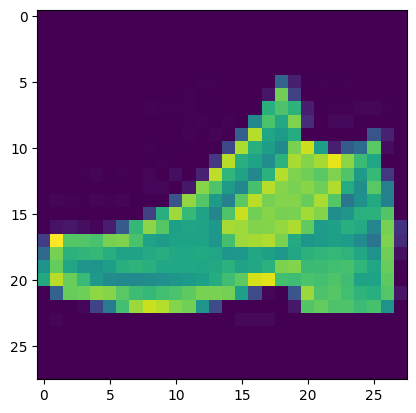

(9, 'Ankle boot')

In [8]:
base_data_path = 'fashion-mnist-data'

def load_data():
    y_data = []
    x_data = []

    with open(f'./{base_data_path}/fashion-mnist_train.csv', "r") as file:
        next(file)
        for index, line in enumerate(file.readlines()):
            y_data.append(int(line.split(",")[0]))
            x_data.append([ int(pixel) for pixel in line.split(",")[1:] ])
            if index >= 16: break
    return x_data, y_data

X_raw,Y_raw = load_data()

x_img = reshape_vector(X_raw[1],28)
plt.imshow(x_img)
plt.show()
Y_raw[1], get_article(Y_raw[1])

### Working with pandas and numpy

In [8]:
df = pd.read_csv(f'./{base_data_path}/fashion-mnist_train.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data = np.array(df)
m, n = data.shape # 60000, 785
np.random.shuffle(data)

data_test = data[0:1000].T # 785, 1000
X_test = data_test[1:n] 
Y_test = data_test[0]

data_train = data[1000:].T
X_train = data_train[1:n]
Y_train = data_train[0]

# Normalization
X_test = X_test / 255
X_train = X_train / 255


In [16]:
data[0:1000].shape
data_train.shape

(785, 59000)

In [13]:
X_train.shape, Y_train.shape, m

((784, 59000), (59000,), 60000)

### Building the Neural Network

In [24]:
def init_params(batch_size=16):
    n_neurons_l2 = 25
    W1 = np.random.randn(batch_size, 784) - 0.5
    b1 = np.zeros(shape=(batch_size, 1))
    W2 = np.random.randn(n_neurons_l2, batch_size) - 0.5
    b2 = np.zeros(shape=(n_neurons_l2, 1))
    W3 = np.random.randn(10, n_neurons_l2) - 0.5
    b3 = np.zeros(shape=(10,1))
    
    return W1, b1, W2, b2, W3, b3

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    z = x - np.max(x, axis=0)
    probs = np.exp(z) / np.sum(np.exp(z), axis=0)
    return probs

def cross_entropy(y_hat, y_one_hot):
    # y_one_hot es un vector con las probabilidades reales (etiquetas verdaderas)
    # y_hat es un vector con las probabilidades predichas por el modelo
    epsilon = 1e-15  # Valor pequeño para evitar divisiones por cero
    y_hat = np.maximum(epsilon, y_hat)  # Asegurarse de que no haya valores cercanos a cero
    return - np.sum(y_one_hot * np.log(y_hat))

def relu_prime(z):
    #z[ z <= 0] = 0
    return z > 0

def one_hot(y, k=10):
    #one_hot_y = np.zeros(shape=(y.size, k))
    #classes = np.arange(y.size)
    #one_hot_y[classes, y] = 1
    one_hot_y = np.zeros((y.size, 10)) # 10 classes
    one_hot_y[np.arange(y.size), y] = 1
    # return the same format as 784 x batch_size
    return one_hot_y.T

def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

def backward_propagation(X, Y_one_hot, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3):
    m = X.shape[1] # 59000

    dZ3 = A3 - Y_one_hot
    dW3 = 1/m * (dZ3 @ A2.T)
    db3 = 1/m * np.sum(dZ3, 1)

    dA2 = W3.T @ dZ3
    dZ2 = dA2 * relu_prime(Z2)
    dW2 = 1/m * (dZ2 @ A1.T)
    db2 =  1/m * np.sum(dZ2, 1)

    dA1 = W2.T @ dZ2
    dZ1 = dA1 * relu_prime(Z1)
    dW1 = 1/m * (dZ1 @ X.T)
    db1 = 1/m * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2, dW3, db3

def update_params(lr, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3):
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1.reshape(16,1)
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2.reshape(25,1)
    W3 = W3 - lr * dW3
    b3 = b3 - lr * db3.reshape(10, 1)
    return W1, b1, W2, b2, W3, b3

def get_batches(total_samples, batch_size=16):
    batches = []
    for split in range(0, total_samples, batch_size):
        if split + batch_size > total_samples: break
        start_index = split
        end_index = split + batch_size #if (split + batch_size <= total_samples)  else  total_samples
        batches.append((start_index, end_index))
    return batches

def get_accuracy(y_hat, y):
    predictions = np.argmax(y_hat, 0)
    return np.sum(predictions == y) / y.size

#get_batches(100)

#A = [[-1, 0.5, -0.23], [0.67, -2.8, 2.12]]
#print(relu(A))
#print(softmax(A))

input_vector = np.array([2, 1.0, 0.1])
softmax(input_vector)

array([0.65900114, 0.24243297, 0.09856589])

Creating a Neural Network with:
- 3 layers: 1 input, 1 hidden, 1 output
- hidden layer

In [18]:
# X_train[:, 32:64].shape
X_train.shape

(784, 59000)

In [25]:
batch_size = 64
epochs = 300
learning_rate = 0.1

def train():
    X = X_train
    Y = Y_train

    W1, b1, W2, b2, W3, b3 = init_params()

    for epoch in range(epochs):
        
        Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)
        y_one_hot = one_hot(Y)
        loss = cross_entropy(A3, y_one_hot) # y_hat - y

        dW1, db1, dW2, db2, dW3, db3 = backward_propagation(X, y_one_hot, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3)
        W1, b1, W2, b2, W3, b3 = update_params(learning_rate, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3)
            
        if epoch == 0 or (epoch + 1) % 100  == 0:
            acc = get_accuracy(A3, Y)
            print(f"Epoc: {epoch + 1}, loss: {round(loss,4)}, acc: {acc}")
            
    return W1, b1, W2, b2, W3, b3
    
W1, b1, W2, b2, W3, b3 = train()

Epoc: 1, loss: 135852.5314, acc: 0.09996610169491525
Epoc: 100, loss: 135852.4973, acc: 0.10020338983050847
Epoc: 200, loss: 135852.4923, acc: 0.10020338983050847
Epoc: 300, loss: 135852.4911, acc: 0.10020338983050847


In [69]:
#one_hot_y = np.zeros((Y_train.size, 10)) 
#one_hot_y[np.arange(Y_train.size), Y_train] = 1
#one_hot_y[1], Y_train[1]
#one_hot_y.T.shape, A3.shape, b1.shape

batch_size = 32
epochs = 5
learning_rate = 0.01

def train():
    params = initialize_params(batch_size)

    total_samples = len(Y_train)
    batches = get_batches(total_samples, batch_size)
    
    for epoch in range(epochs):
        i = 0
        for start_index, end_index in batches:
            X = X_train[:, start_index:end_index]
            Y = Y_train[start_index:end_index]

            params = forward_propagation(X, params)

            loss, params = backward_propagation(X, Y, params)

            params = update_params(learning_rate, params)
            
            if i % 100 == 0:
                acc = get_accuracy(params['A3'], Y)
                print(f"Epoc: {epoch + 1}, batch:  {i}/{len(batches)}, loss: {round(loss,4)}, acc: {acc}")
            
            i += 1

    return params
    
params = train()

## Inferences

In [93]:
random_item = 10
Y_item_test = Y_test[random_item]
X_item_test = X_test[:, random_item, None]

Y_item_test, get_article(Y_item_test)

(0, 'T-shirt/top')

In [94]:
def predict(index, X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)
    predictions = np.argmax(A3, 0)
    return predictions[index]

item_predicted = predict(random_item, X_item_test, W1, b1, W2, b2, W3, b3)
item_predicted, get_article(item_predicted)

IndexError: index 10 is out of bounds for axis 0 with size 1

In [95]:
#X_test[:, random_item, None].shape
_, _, _, _, _, A3 = forward_propagation(X_item_test, W1, b1, W2, b2, W3, b3)
A3.shape

(10, 1)

#### Actual Image

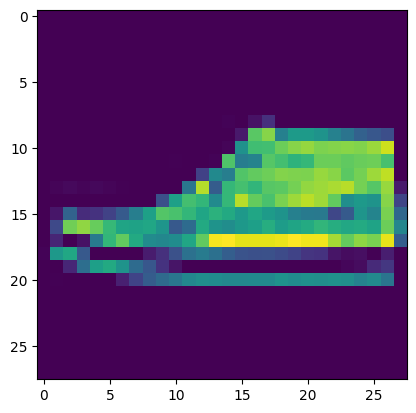

In [ ]:
img = X_item_test.reshape((28, 28)) * 255
plt.imshow(img)
plt.show()